#### Import modules

In [10]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


In [4]:
dc = datacube.Datacube(app='Alberts Forest')

#### Import training data csv

In [12]:
path = 'WCF_traindata_22102019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.261320,0.034313,0.047605,0.052131,0.19575,0.14400,0.082638
1,0.116210,0.044998,0.067579,0.083996,0.20979,0.25615,0.160270
2,0.408240,0.022349,0.035390,0.040748,0.19127,0.11858,0.070578
3,0.000000,0.048717,0.077072,0.091846,0.24272,0.29843,0.190590
4,0.053365,0.059975,0.087660,0.104420,0.23314,0.27891,0.184080


#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

In [13]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# Define model
model = RandomForestRegressor(n_estimators=10, random_state=30)

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

# Metrics
print('Accuracy = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html

# Determine the importance of each of the bands
#print(model.feature_importances_) # need to format nicely
feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)


Accuracy = 
0.8658457347096035
 red      0.613435
 nir      0.115798
 swir1    0.097775
 green    0.086500
blue      0.048595
 swir2    0.037898
dtype: float64


#### Choose location

Whroo in Victoria is the location of some training data

In [6]:
# Set the central latitude and longitude
central_lat = -36.70287 
central_lon = 145.01171

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [24]:
start_date = '2017'
end_date = '2017' 

#Load all data in baseline period available from Near Real Time data

baseline_da = dc.load(
              product='ls8_nbart_geomedian_annual',
              x=study_area_lon,
              y=study_area_lat,
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              resolution=(-10, 10),
              #group_by='solar_day'
)
baseline_da

<xarray.Dataset>
Dimensions:  (time: 1, x: 2008, y: 2386)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01
  * y        (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06
  * x        (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
Data variables:
    blue     (time, y, x) int16 578 578 548 548 548 713 ... 584 584 568 568 589
    green    (time, y, x) int16 796 796 785 785 785 965 ... 833 833 816 816 836
    red      (time, y, x) int16 968 968 962 962 962 ... 1037 1037 1008 1008 1055
    nir      (time, y, x) int16 2521 2521 2614 2614 2614 ... 2654 2675 2675 2570
    swir1    (time, y, x) int16 2651 2651 2420 2420 2420 ... 2536 2456 2456 2546
    swir2    (time, y, x) int16 1726 1726 1587 1587 1587 ... 1839 1757 1757 1874
Attributes:
    crs:      EPSG:3577

#### Choose location

Whroo in Victoria is the location of some training data

#### Prepare dataset to go in model

In [25]:
flat = sklearn_flatten(baseline_da)
flat

array([[ 578,  796,  968, 2521, 2651, 1726],
       [ 578,  796,  968, 2521, 2651, 1726],
       [ 608,  860, 1063, 2415, 2967, 1933],
       ...,
       [ 624,  873, 1125, 2479, 2691, 2013],
       [ 624,  873, 1125, 2479, 2691, 2013],
       [ 589,  836, 1055, 2570, 2546, 1874]], dtype=int16)

#### Run model

In [26]:
results = model.predict(flat)
results

array([0., 0., 0., ..., 0., 0., 0.])

#### Unflatten results

In [27]:
unflat = sklearn_unflatten(results,baseline_da)
unflat

<xarray.DataArray (x: 2008, y: 2386, time: 1)>
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])
Coordinates:
  * x        (x) float64 1.153e+06 1.153e+06 1.153e+06 ... 1.173e+06 1.173e+06
  * y        (y) float64 -4.059e+06 -4.059e+06 ... -4.082e+06 -4.082e+06
  * time     (time) datetime64[ns] 2017-01-01

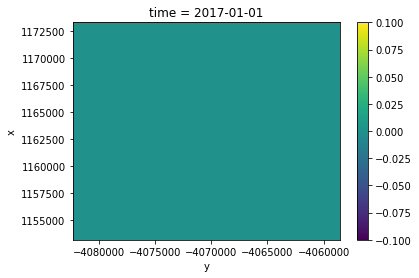

In [28]:
unflat.plot()